## Exercise: Demonstration of several algorithms on a toy dataset 

Exercises using the Pen Digits Dataset: https://www.dbs.ifi.lmu.de/research/outlier-evaluation/DAMI/literature/PenDigits/PenDigits_v01.html

The data is already present in .pkl format (oad the data below).
This data set was created by recording the writing pattern of digits on a digital writing pad. The digit "4" is downsampled to only 20 instances, making it an outlier. 

Note that (unlike MNIST), the features do not simply correspond to pixels.

This dataset is small and simple: it has only numeric features and no NaN's, and is an ideal starting point to test various algorithms. 


## Imports

In [2]:
# standard library imports
import os
import sys
from collections import Counter

# pandas, seaborn etc.
import seaborn as sns
import sklearn 
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np

# sklearn outlier models
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN

# other sklearn functions
from sklearn.decomposition import PCA
from sklearn.covariance import MinCovDet, EmpiricalCovariance
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import scale as preproc_scale
from sklearn.manifold import TSNE

# pyod
import pyod
from pyod.models.auto_encoder import AutoEncoder
from pyod.models.knn import KNN   



Using TensorFlow backend.


In [3]:
sys.path.append("..") #to enable importing from ../outlierutils
from outlierutils import plot_top_N, plot_outlier_scores # For easy plotting and evaluation

## Data loading

In [7]:
data_path = '../data/'
x_pen = pd.read_pickle(os.path.join(data_path, 'x_pendigits.pkl'))
y_pen = pd.read_pickle(os.path.join(data_path, 'y_pendigits.pkl'))

# Scale and put again into a DataFrame
sc = StandardScaler()
x_pen = pd.DataFrame(data=sc.fit_transform(x_pen))

In [8]:
print('Number of points: {}'.format(len(y_pen)))
print('Number of positives: {} ({:.3%})'.format(y_pen.sum(), y_pen.mean()))

Number of points: 9868
Number of positives: 20 (0.203%)


## Usage of plotting functions

Find examples how to plot the conditional scores and the top-N ranking below

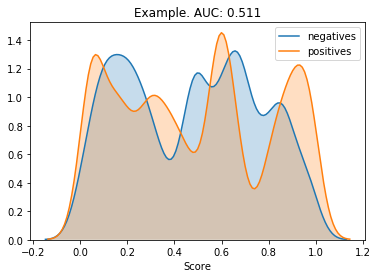

In [41]:
# example with random data
y_true_, scores_ = np.random.choice([0, 1], 100), np.random.uniform(size=100)
results = plot_outlier_scores(y_true=y_true_, 
                            scores=scores_, 
                            bw=0.05, 
                            title='Example.')

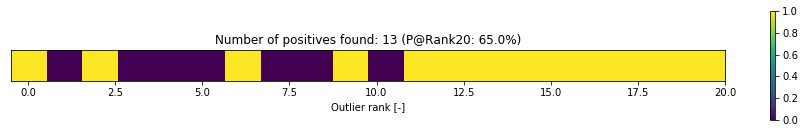

In [40]:
results = plot_top_N(y_true=y_true_, scores=scores_, N=20)

### 0. (Optional): Data visualization

Reduce the dimensionality with T-SNE, and visualize the positive and negative class in a scatter plot. 
What do you observe?

In [9]:
## Downsample the negative class to size ~3000
N_downsample = 3000
assert x_pen.index.equals(y_pen.index), 'Error, indexes differ. Reset them to continue'
x_downsampled = pd.concat((x_pen[y_pen==0].sample(N_downsample - int(y_pen.sum())),
                           x_pen[y_pen==1]), 
                          axis=0)
y_downsampled = y_pen[x_downsampled.index]

In [13]:
## Use TSNE().fit_transform(data) and make a scatterplot, using a separate color for the outliers

## 1a. Mahalonobis Distance, single cluster

Using `EmpiricalCovariance`, or `MinCovDet`, do a `.fit()` to get the covariance matrix. 
Determine the distance with `.mahalonobis()` and use this as outlier score

## 1b. Mahalonobis Distance, GMM



### 2. KNN algorithm


#### Q 2.1 
With the scikit-learn NearestNeighbors class, determine the probability of the nearest neighbour of a point being an outlier, conditional on the class membership of that point. Note how this corresponds to the insight from the t-SNE visualization
 
**HINTS**: 
- *The output of clf.kneighbors() (after doing clf.fit()) is a tuple, the first element being an array with distances, the second element being an array with indexes of neighbours. The first column corresponds to the points themselves. Therefore, get the indices of the nearest neigbours using the code provided in the next cell.*

In [42]:
# clf_nn = NearestNeighbors(n_neighbors=...)
# clf_nn.fit(x_pen)
# nearest_1st_ns = clf_nn.kneighbors(x_pen)[1][:, 1] # to get the indices of the first nearest neighbour for each point


#### Q 2.2 
Use pyod's KNN class to detect the outliers. 
Use `method=median`, and guess a reasonable value for `n_neighbors`based on the insights from t-SNE and the previous question. 

Plot the conditional score curves and the top-100 results, using `plot_outlier_scores` and `plot_top_N`. 

Vary n_neighbors, how does it affect AUC and precision@100?

**HINTS**: 
- *Use clf.decision_scores_ to get the outlier scores (and not the binary labels, that are stored in clf.labels_)*
- *Both plot_outlier_scores and plot_top_N expect numpy arrays. To get them from a Series, add `.values`*
- *Example usage for the plot functions are given below*


### 3. LOF algorithm


## Demo of algorithms

### 1. K-nearest neighbours

#### 1.1 Use the scikit-learn NearestNeighbors implementation to get neighbor statistics.



In [15]:
def get_median_distance(X, n_points=1, skip_first_distance=True):
    """
    X (np.array): distance array, shape Nxn_neighbors
    n_points (int): number of points to calculate the median distance from
    skip_first_distance (boolean or int): if True (or 1), the first column is ignored
    """
    dist_array=np.zeros(len(X))
    for i in range(len(X)):
        dist_array[i] = np.median(X[i][int(skip_first_distance):int(skip_first_distance) + n_points])
    return dist_array
        


In [78]:
clf_nb = NearestNeighbors(n_neighbors=31)
clf_nb.fit(x_pen)
neighbor_distances = clf_nb.kneighbors(x_pen)[0] #1st array contains distances, 2nd contains points


In [79]:
n_points = 1
median_knn_pen = get_median_distance(neighbor_distances, n_points=n_points)

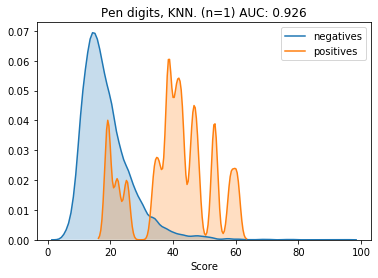

In [80]:
res = plot_outlier_scores(y_pen.values, median_knn_pen, bw=1, title='Pen digits, KNN. (n={})'.format(n_points))

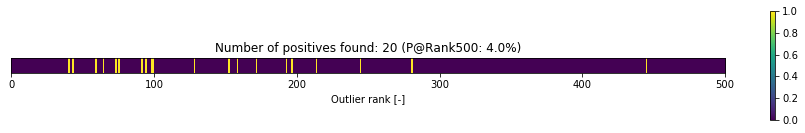

In [19]:
res = plot_top_N(y_pen.values, median_knn_pen, N=500)

#### 1.2 Use pyod

In [76]:
# train kNN detector
clf_name = 'KNN'
clf = KNN(method='median', n_neighbors=31)
clf.fit(x_pen)

# get the prediction label and outlier scores of the training data
y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores = clf.decision_scores_  # raw outlier scores

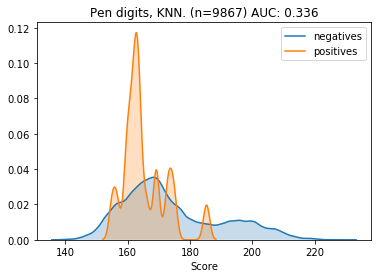

In [77]:
res = plot_outlier_scores(y_pen.values, clf.decision_scores_, bw=1, 
                          title='Pen digits, KNN. (n={})'.format(clf.n_neighbors))

### 2. LOF

In [24]:
clf_list = [LocalOutlierFactor(n_neighbors=n, contamination=0.01) for n in (3, 31)] #NB: we won't use contamination
pred_list = [clf_.fit_predict(x_pen) for clf_ in clf_list]

**Example 1:** N_neighbours too low (N=3)

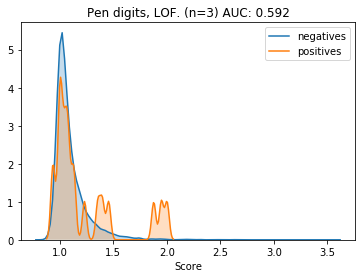

In [25]:
res = plot_outlier_scores(y_pen.values, -clf_list[0].negative_outlier_factor_, 
                          bw=0.02, title='Pen digits, LOF. (n=3)')

**Example 2:** N_neighbours good (N=31)

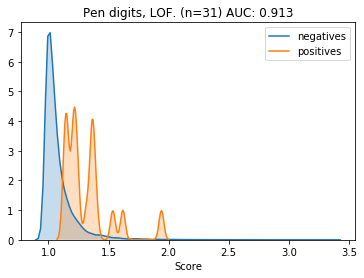

In [26]:
res = plot_outlier_scores(y_pen.values, -clf_list[1].negative_outlier_factor_, bw=0.02, 
                          title='Pen digits, LOF. (n=31)')

### 3. Isolation Forest

In [27]:
ifo = IsolationForest(n_estimators=100, max_samples=1024, random_state=1, contamination=0.01, behaviour='new')
ifo.fit(x_pen)
pen_isof_scores = - ifo.decision_function(x_pen)

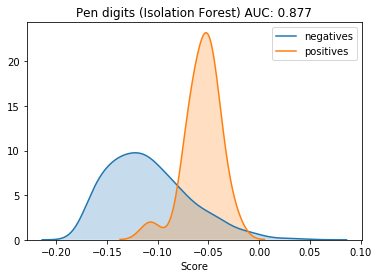

In [28]:
res = plot_outlier_scores(y_pen.values, pen_isof_scores, bw=0.01, title='Pen digits (Isolation Forest)')

Note the rather large variation of AUC ROC scores by doing 10 calculations with different random seeds:

In [29]:
ifo_clfs = [IsolationForest(n_estimators=100, max_samples=512, random_state=i, contamination=0.01, behaviour='new')
            .fit(x_pen) for i in range(10)]
scores = [roc_auc_score(y_pen.values, -ifo_clf.decision_function(x_pen)) for ifo_clf in ifo_clfs]

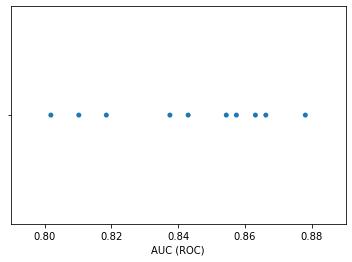

In [30]:
fig, ax = plt.subplots(1, 1)
ax.set_xlabel('AUC (ROC)')
sns.swarmplot(scores, ax=ax);

### 4. Mahalonobis Distance

We can calculate the Mahalonobis distance in two ways:
- Directly: Calculating the Covariance matrix (with the full data, or with the robust MinCovDet), then the Mahalonobis distance
- Indirectly: Do a whitened PCA decompose with full-rank, calculate the Euclidean distance

In [32]:
cov_ = EmpiricalCovariance().fit(x_pen)
#cov_ = MinCovDet().fit(x_pen) # Robust estimation
mahalonobis_pen = cov_.mahalanobis(x_pen)

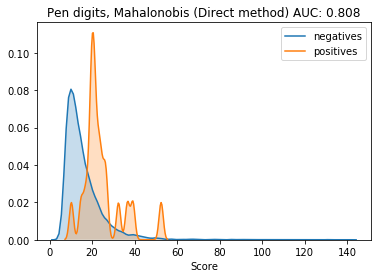

In [34]:
res = plot_outlier_scores(y_pen.values, mahalonobis_pen, bw=1, title='Pen digits, Mahalonobis (Direct method)')

In [55]:
pca = PCA(n_components=x_pen.shape[1], whiten=True)

In [56]:
x_pen_pcafull = pca.fit_transform(x_pen)

In [57]:
# sns.heatmap(pd.DataFrame(data=x_pen_pcafull).corr());

In [58]:
mahalonobis_pca = (x_pen_pcafull**2).sum(axis=1)

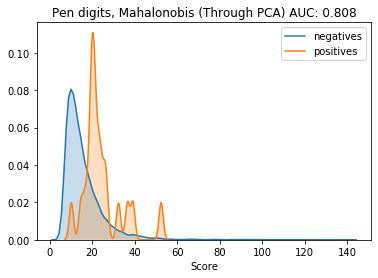

In [59]:
res = plot_outlier_scores(y_pen.values, mahalonobis_pca, bw=1, title='Pen digits, Mahalonobis (Through PCA)')

### 5. DBSCAN

In [81]:
def make_dbscan_outlierscore(labels):
    """ Returns outlier scores from db scan labels
    The -1 cluster are defined as outliers, and get the highest outlier score
    Other clusters: the smaller the cluster, the larger the outlier score
    
    labels (np.ndarray) : cluster labels
    
    Returns: outlier_scores (np.ndarray)
    """
    cluster_counter = Counter(labels)
    del cluster_counter[-1] # Outliers will get score 1 at the end
    cluster_label, cluster_size = (np.array(list(cluster_counter.keys())), 
                                   np.array(list(cluster_counter.values())))
    
    cluster_order = cluster_label[np.argsort(cluster_size)][::-1]
    scores = np.array(range(len(cluster_label))) / len(cluster_label)
    cluster_mapping = {c:s for c, s in zip(cluster_order, scores)}
    cluster_mapping = {**cluster_mapping, -1:1}
    outlier_scores = np.vectorize(cluster_mapping.get)(labels)
    return outlier_scores
    
    

DBSCAN has two parameters to choose. min_samples has a smaller influence than epsilon. Larger epsilon results in fewer clusters. A somewhat smaller epsilon (resulting in ~10 clusters) seems beneficial. 

In [82]:
db = DBSCAN(eps=1.5, min_samples=10)
db.fit(x_pen_scaled)

DBSCAN(algorithm='auto', eps=1.5, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=10, n_jobs=None, p=None)

In [83]:
db_outlier_scores = make_dbscan_outlierscore(db.labels_)

In [34]:
len(np.unique(db.labels_))

11

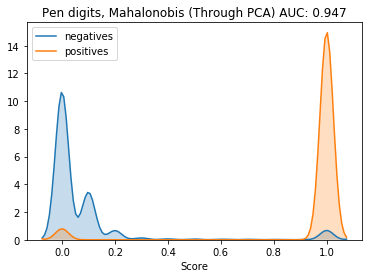

In [35]:
res = plot_outlier_scores(y_pen.values, db_outlier_scores, bw=0.025, title='Pen digits, Mahalonobis (Through PCA)')

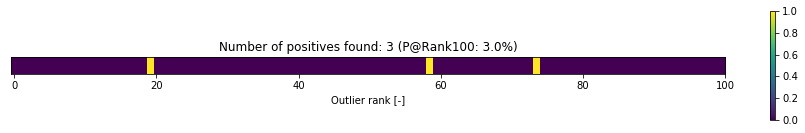

In [36]:
res = plot_top_N(y_pen.values, db_outlier_scores, N=100)

In [37]:
roc_scores_dbscan = {eps: roc_auc_score(y_pen.values, 
                                        make_dbscan_outlierscore(DBSCAN(eps=eps, min_samples=10)
                                                                 .fit(x_pen_scaled)
                                                                 .labels_)) 
                     for eps in  [0.5, 1.0, 1.5, 2.0, 2.5, 3.0]}

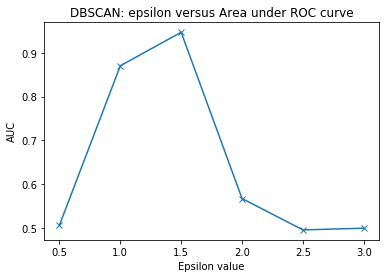

In [38]:
plt.plot(list(roc_scores_dbscan.keys()), list(roc_scores_dbscan.values()), '-x');
plt.xlabel('Epsilon value')
plt.ylabel('AUC')
plt.title('DBSCAN: epsilon versus Area under ROC curve');

### 6. PCA reconstruction error

In [84]:
pca = PCA(n_components=15, whiten=True)
pca_tf = pca.fit_transform(x_pen)
x_pen_recon = pca.inverse_transform(pca_tf)

In [85]:
pca_recon = ((x_pen - x_pen_recon)**2).sum(axis=1)
pca_recon = np.clip(pca_recon, 0, 200) # clip for plotting purposes

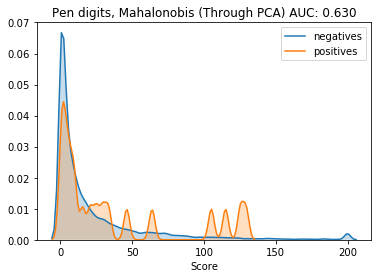

In [87]:
res = plot_outlier_scores(y_pen.values, pca_recon.values, bw=2, title='Pen digits, Mahalonobis (Through PCA)')

### 7a. Autoencoder, outlier formulation (all points used for training)

In [88]:
clf = AutoEncoder(
    hidden_neurons=[15, 14, 15],
    hidden_activation='elu',
    output_activation='linear',
    optimizer='adam',
    epochs=20,
    batch_size=16,
    dropout_rate=0.0,
    l2_regularizer=0.0,
    validation_size=0.1,
    preprocessing=True, #NB: this uses sklearn's StandardScaler (not [0, 1] --> do not use sigmoid output activation!)
    verbose=1,
    random_state=1,
    contamination=0.1,
)

In [89]:
clf.fit(x_pen)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 15)                255       
_________________________________________________________________
dropout_3 (Dropout)          (None, 15)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 14)               

AutoEncoder(batch_size=16, contamination=0.1, dropout_rate=0.0, epochs=20,
      hidden_activation='elu', hidden_neurons=[15, 14, 15],
      l2_regularizer=0.0,
      loss=<function mean_squared_error at 0x7fd20ee5f048>,
      optimizer='adam', output_activation='linear', preprocessing=True,
      random_state=1, validation_size=0.1, verbose=1)

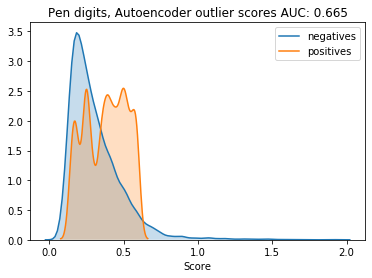

In [90]:
y_train_scores = clf.decision_scores_  # raw outlier scores
res = plot_outlier_scores(y_pen.values, y_train_scores, bw=0.025, title='Pen digits, Autoencoder outlier scores')

**Check the reconstruction error visually**

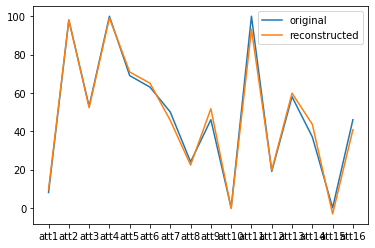

In [91]:
x_pen_scaled_recon = clf.model_.predict(x_pen_scaled)
x_pen_recon = sc.inverse_transform(x_pen_scaled_recon)
plt.plot(x_pen.iloc[0, :], label='original')
plt.plot(x_pen_recon[0, :], label='reconstructed');
plt.legend();

### 7b. Autoencoder, novelty formulation 

Note that this is cheating: we are using only negatives for fitting.
Since there are only ~0.2% positives, this will not make a large difference. 
We use a bottleneck layer that is only one size smaller than the input/output dimension (16)

In [46]:
x_pen_negatives = x_pen.loc[y_pen==0]

In [69]:
clf = AutoEncoder(
    hidden_neurons=[16, 15, 16],
    hidden_activation='elu',
    output_activation='linear',
    optimizer='adam',
    epochs=20,
    batch_size=16,
    dropout_rate=0.0,
    l2_regularizer=0.0,
    validation_size=0.1,
    preprocessing=True, #NB: this uses sklearn's StandardScaler (not [0, 1] --> do not use sigmoid output activation!)
    verbose=1,
    random_state=1,
    contamination=0.1,
)

In [70]:
clf.fit(x_pen_negatives)


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_29 (Dense)             (None, 16)                272       
_________________________________________________________________
dropout_23 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_30 (Dense)             (None, 16)                272       
_________________________________________________________________
dropout_24 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_31 (Dense)             (None, 16)                272       
_________________________________________________________________
dropout_25 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_32 (Dense)             (None, 15)               

AutoEncoder(batch_size=16, contamination=0.1, dropout_rate=0.0, epochs=20,
      hidden_activation='elu', hidden_neurons=[16, 15, 16],
      l2_regularizer=0.0,
      loss=<function mean_squared_error at 0x7f4c596070d0>,
      optimizer='adam', output_activation='linear', preprocessing=True,
      random_state=1, validation_size=0.1, verbose=1)

In [71]:
# Transform all points (neg and pos)
sc = StandardScaler()
x_pen_scaled = sc.fit_transform(x_pen)
x_pen_scaled_recon = clf.model_.predict(x_pen_scaled)
x_pen_recon = sc.inverse_transform(x_pen_scaled_recon)

In [72]:
# Calculate reconstruction error
rec_error_novelty = np.mean((x_pen - x_pen_recon)**2, axis=1)
rec_error_novelty = np.clip(rec_error_novelty, 0, 40)

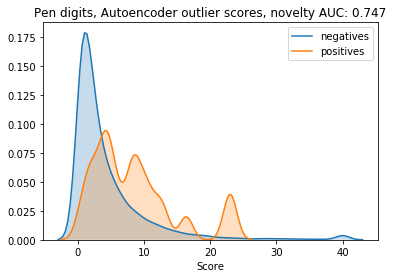

In [73]:
y_train_scores = clf.decision_scores_  # raw outlier scores
res = plot_outlier_scores(y_pen.values, rec_error_novelty, bw=1, 
                          title='Pen digits, Autoencoder outlier scores, novelty')


## Conclusions

The KNN algorithm performs best, with a AUC of 0.986 (similar to the result on the webpage above, for K=19). 
LOF is a good second (0.92). The DBSCAN algorithm has the potential to do very good (AUC 0.95), but is very sensitive for epsilon, which is a difficult parameter to tune. 

The Isolation Forest algorithm is decent (AUC 0.80 - 0.88, depending on random seed, with 100 trees), but not really suited to this data (note that the tree-splitting process makes it not invariant for rotation of the data), and more suited for mixed or categorical data. 

The straightforward Mahalonobis algorithm that has no tuning parameters scores a decent 0.81. 

The reconstruction algorithms (PCA and Autoencoder) don't do too well, between 0.6 and 0.7, except for the novelty formulation for the autoencoder (0.75), which is, however, not quite unsupervised. Autoencoders may be tuned further for better performance, but this is not realistic in an unsupervised scenario. 


In [ ]:
url = "https://unsupervised-label-api-pg.herokuapp.com/"
